# _Experimentation: February 17, 2020_

**TL;DR** --> Continue exploration of tweets with t-SNE and UMAP

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

## _Create Path_

In [2]:
# import os library to better help us navigate directories (which in this) case is our Google Drive
import os

# what is our current working directory?
print("Our current working directory is '{}'.".format(os.getcwd()))

Our current working directory is '/notebooks/IRA-Twitter-Disinformation'.


## _Load Data_

In [3]:
from pathlib import Path

#create path variable to primary directory
path = Path(os.getcwd())
path

PosixPath('/notebooks/IRA-Twitter-Disinformation')

In [4]:
def tree(directory):
    print(f'+ {directory}')
    for path in sorted(directory.rglob('*')):
        depth = len(path.relative_to(directory).parts)
        spacer = '    ' * depth
        print(f'{spacer}+ {path.name}')

In [5]:
tree(path.cwd())

+ /notebooks/IRA-Twitter-Disinformation
    + .ipynb_checkpoints
        + exp2_feb16-checkpoint.html
        + exp2_feb16-checkpoint.ipynb
        + exp_altair-checkpoint.html
        + exp_altair-checkpoint.ipynb
        + feb17_exp-checkpoint.ipynb
    + chart.html
    + data
        + everything_2020_02_07.pkl
    + exp2_feb16.html
    + exp2_feb16.ipynb
    + exp_altair.html
    + exp_altair.ipynb
    + exp_nbs
        + .ipynb_checkpoints
            + exp2_jan27-checkpoint.html
            + exp2_jan27-checkpoint.ipynb
            + exp_jan27-checkpoint.html
            + exp_jan27-checkpoint.ipynb
        + exp2_jan27.html
        + exp2_jan27.ipynb
        + exp_jan27.html
        + exp_jan27.ipynb
    + feb17_exp.ipynb


In [6]:
import pandas as pd

df = pd.read_pickle(path/"data/everything_2020_02_07.pkl")

In [7]:
# convert USERNAME to categorical type
df["USERNAME"] = df["USERNAME"].astype("category")

In [8]:
# convert LABEL column to categorical type
df["LABEL"] = df["LABEL"].astype("category")

In [9]:
# take a sample to work with
sample = df.sample(n=1000, random_state=1).sort_values("CREATED_AT", ascending=False).reset_index(drop=True)

## _Pre-processing Text Data_

In [10]:
import string
import re
import demoji
demoji.download_codes()

punctuation = string.punctuation + "—"

... OK (Got response in 0.14 seconds)
Writing emoji data to /root/.demoji/codes.json ...
... OK


In [11]:
from tqdm.notebook import tqdm
tqdm.pandas()

In [12]:
def clean_tweet(text):
    # remove punctuation
    text = "".join([char for char in text if char not in punctuation])
    # remove numbers
    text = re.sub("[0-9]+", "", text)
    #remove links
    text = re.sub(r"http\S+", "", text)
    # remove emjois
    text = demoji.replace(text, "")
    return text

In [13]:
sample["preprocess"] = sample["TWEET"].progress_apply(lambda x: clean_tweet(x))

## _spaCy_

In [14]:
import spacy

nlp = spacy.load("en_core_web_md")

In [15]:
doc = nlp(sample["preprocess"][2:3].iloc[0])

In [16]:
for token in doc:
    print(token.text, token.lemma_, token.pos_)

“ " PUNCT
All all DET
of of ADP
a a DET
sudden sudden ADV
we -PRON- PRON
were be AUX
out out ADV
and and CCONJ
then then ADV
hundreds hundred NOUN
of of ADP
people people NOUN
started start VERB
coming come VERB
in in ADP
asking ask VERB
for for ADP
face face NOUN
masks mask NOUN
     SPACE


In [17]:
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS

parser = English()

In [18]:
def spacy_tokenizer(text):
    # creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(text)
    # lemmatize each token and convert into lowercase
    mytokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens]
    # removing stop words
    mytokens = [word for word in mytokens if word not in STOP_WORDS and word not in string.punctuation]
    return mytokens

In [19]:
# create column with tokens
sample["spacy_tokens"] = sample["preprocess"].progress_apply(lambda x: spacy_tokenizer(x))

In [20]:
sample["string_tokens"] = sample["preprocess"].progress_apply(lambda x: " ".join(spacy_tokenizer(x)))

## _Experimentation: t-SNE_

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from yellowbrick.text import TSNEVisualizer

/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [22]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(sample["string_tokens"])
y = sample["LABEL"]

In [23]:
tsne = TSNEVisualizer(labels=sample["LABEL"].unique(), random_state=1)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
/opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


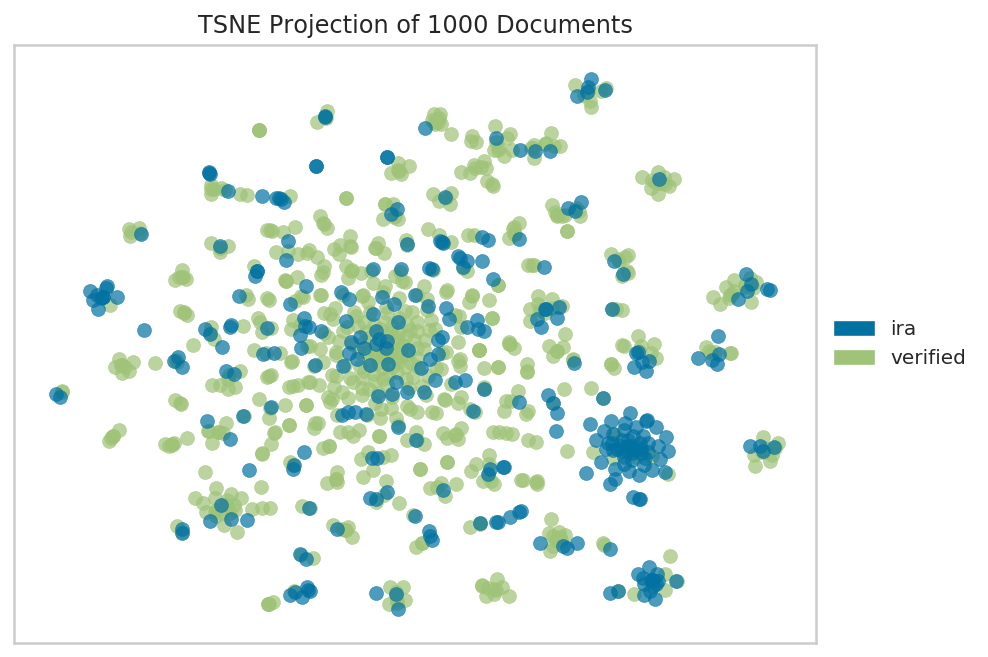

In [24]:
tsne.fit(X, y)
tsne.show()

## _Experimentation UMAP_

In [25]:
#!pip install --upgrade umap-learn

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from yellowbrick.text import UMAPVisualizer

In [31]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(sample["string_tokens"])
y = sample["LABEL"]

In [32]:
umap = UMAPVisualizer(random_state=1)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


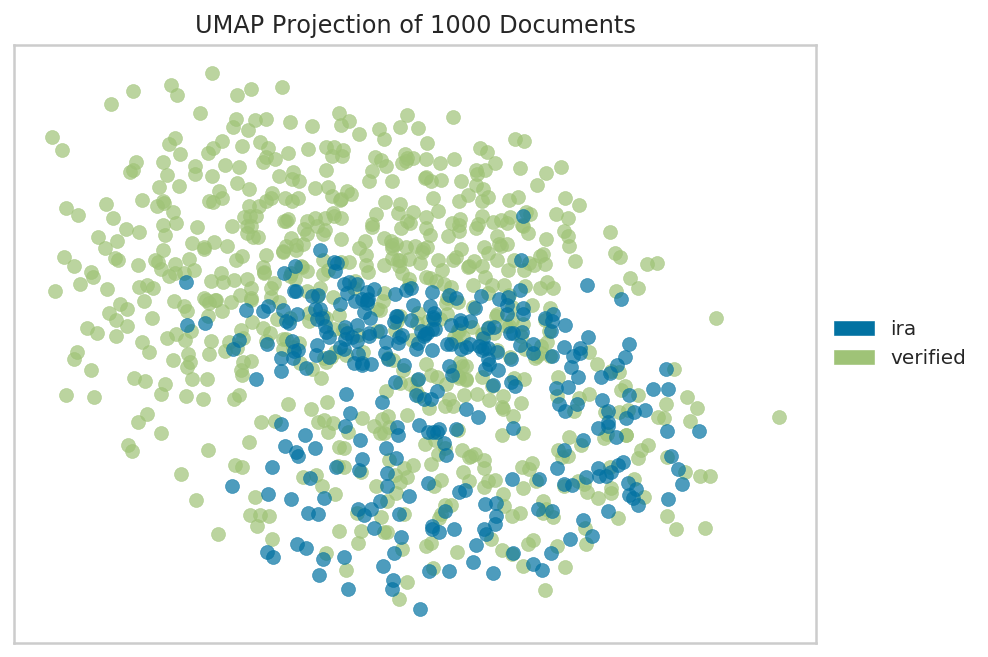

In [33]:
umap.fit(X, y)
umap.show()

## _UMAP library trial_

In [66]:
import umap
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import seaborn as sns

In [49]:
tfidf = TfidfVectorizer(norm="l1")

In [106]:
X = tfidf.fit_transform(sample["string_tokens"])
X

<1000x4839 sparse matrix of type '<class 'numpy.float64'>'
	with 8018 stored elements in Compressed Sparse Row format>

In [117]:
embedding = umap.UMAP(metric="cosine", n_components=50, min_dist=0, random_state=42).fit_transform(X.todense())

In [74]:
ira = pd.get_dummies(sample["LABEL"])["ira"]

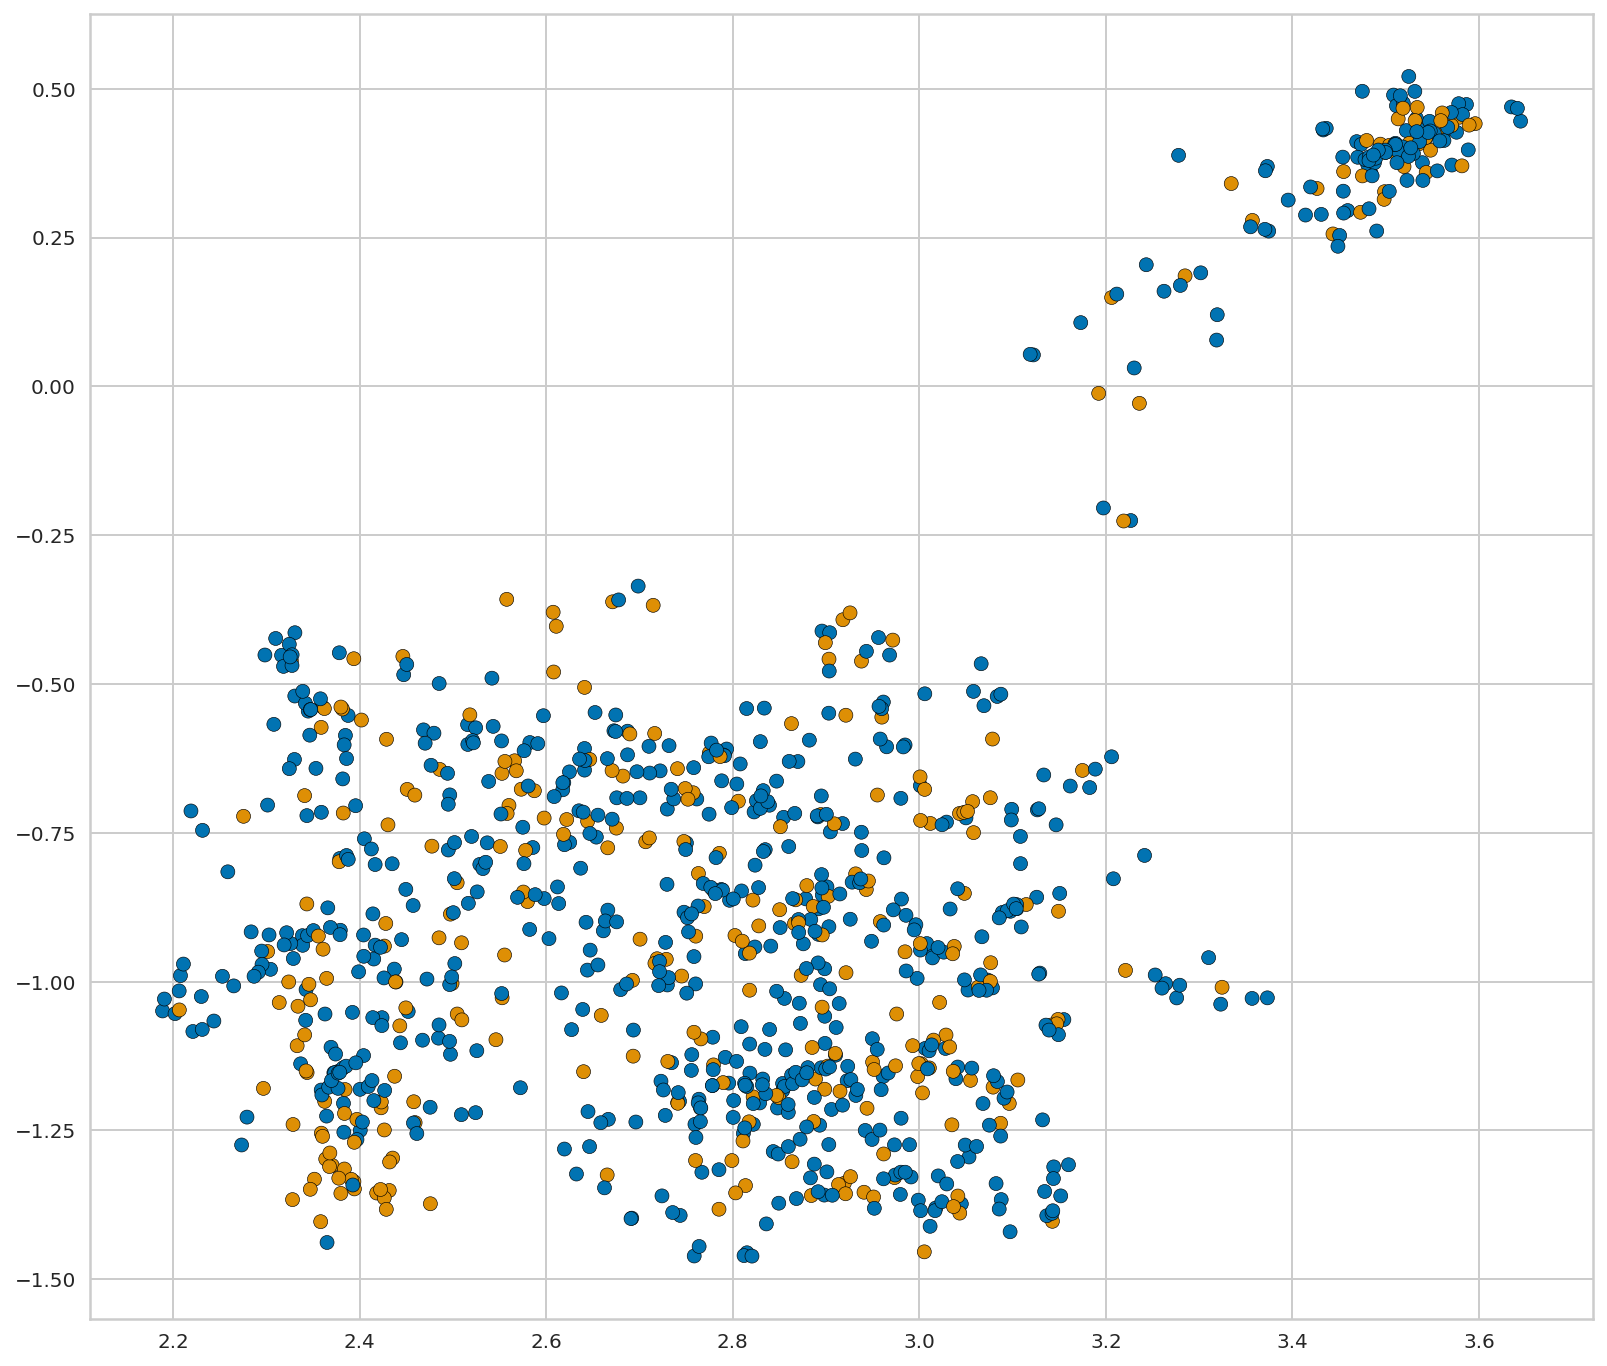

In [118]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
plt.scatter(
    embedding[:, 0], 
    embedding[:, 1], 
    c=[sns.color_palette("colorblind", 2)[x] for x in ira],
    edgecolor="black")

In [42]:
fit = umap.UMAP()
u = fit.transform(sample["string_tokens"])

ValueError: could not convert string to float: 'julius got hot start early night getspectrum pictwittercomcxlxcfh'

ValueError: 'c' argument must either be valid as mpl color(s) or as numbers to be mapped to colors. Here c = BuGr.

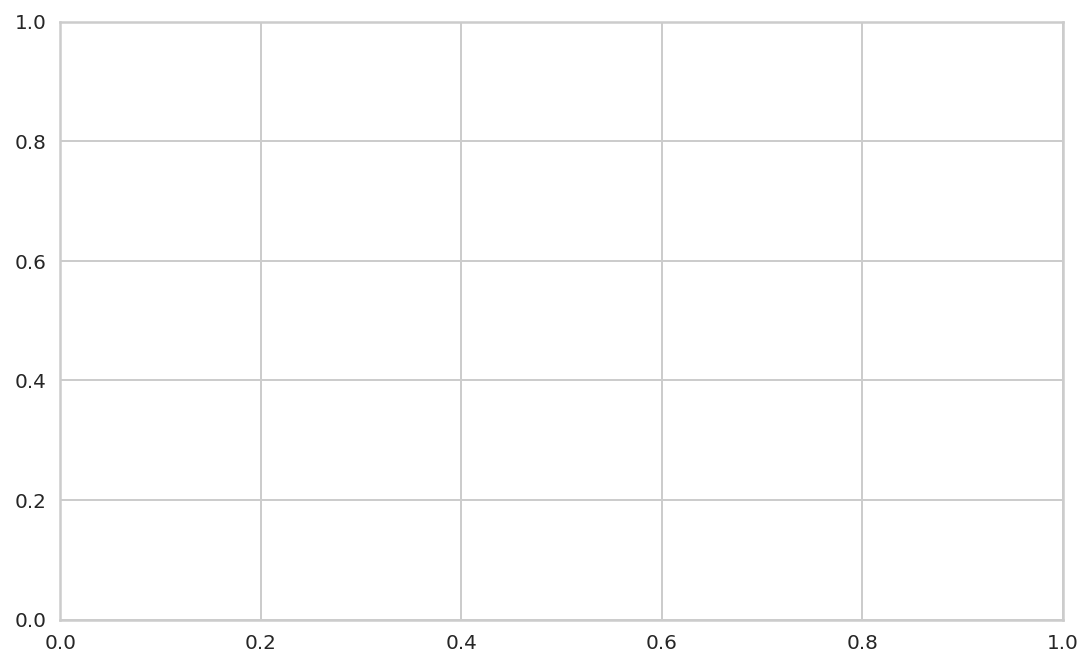

In [41]:
plt.scatter(u[:,0], u[:,1], c="BuGr")